Author: Luke Papaevangeliou  
Project Type: Operational Data Analysis  
Tools: Python, Pandas, Matplotlib  
Dataset: Real-world infrastructure monitoring data

# **Water Network Quality Analysis**

## Overview
This project analyzes operational water-quality measurements from a distribution network to identify compliance risks and operational trends.

Dataset size: ~79862 measurements  
Locations analyzed: multiple network sample points  

## Tools Used
- Python
- Pandas
- Matplotlib

## Key Questions
- Which locations have the highest breach frequency?
- Which locations have the highest breach rate?
- How does Free Chlorine vary across the network?
- Does temperature affect chlorine levels?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (10,6)

## Data Loading

The dataset was loaded from CSV and inspected to verify structure, size, and column names before cleaning.

In [2]:
df = pd.read_csv("../data/raw/network_data.csv", low_memory=False)

print("Rows:", len(df))
print("Columns:", len(df.columns))
df.head()


Rows: 79862
Columns: 19


,Limit Breached,Ext.,Result Date,Parameter,Locality,Sample Point,Site Code,Data Qualifier,Result,UOM,Comment,HasAttachments,Date Sent,Import Reference,Import Batch No,Import Sample Type,User,_NODE_NUM,Zone
0,False,True,3/11/2025 13:48,"Chlorine, Free",NaN,ZONE_CB_NODE_16,SC_06072C3C50,=,0.53,mg/L,NaN,False,NaN,NaN,25-67366,ROUTINE,USR_C2AF552FA7,1,ZONE_CB
1,False,True,3/11/2025 13:48,"Chlorine, Total",NaN,ZONE_CB_NODE_16,SC_06072C3C50,=,0.62,mg/L,NaN,False,NaN,NaN,25-67366,ROUTINE,USR_C2AF552FA7,2,ZONE_CB
2,False,True,3/11/2025 13:48,Temperature,NaN,ZONE_CB_NODE_16,SC_06072C3C50,=,18.50,°C,NaN,False,NaN,NaN,25-67366,ROUTINE,USR_C2AF552FA7,3,ZONE_CB
3,False,True,3/11/2025 13:48,pH field,NaN,ZONE_CB_NODE_16,SC_06072C3C50,=,7.60,units,NaN,False,NaN,NaN,25-67366,ROUTINE,USR_C2AF552FA7,4,ZONE_CB
4,False,True,3/11/2025 13:30,"Chlorine, Free",NaN,ZONE_CB_NODE_14,SC_AF11537CD8,=,0.38,mg/L,NaN,False,NaN,NaN,25-67366,ROUTINE,USR_C2AF552FA7,5,ZONE_CB


## Data Cleaning

To make the dataset analysis-ready, I:
- Converted **Result Date** to datetime
- Converted **Result** to numeric (invalid entries become NaN)
- Kept only the columns needed for operational analysis:
  - Limit Breached, Result Date, Parameter, Sample Point, Result
- Removed empty / invalid rows

This reduces noise and ensures consistent plotting and grouping.

In [3]:
# Covert Date column to datetime
df["Result Date"] = pd.to_datetime(df["Result Date"], errors="coerce")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79862 entries, 0 to 79861
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Limit Breached      79862 non-null  bool          
 1   Ext.                79862 non-null  bool          
 2   Result Date         30873 non-null  datetime64[ns]
 3   Parameter           79862 non-null  object        
 4   Locality            0 non-null      float64       
 5   Sample Point        79862 non-null  object        
 6   Site Code           79862 non-null  object        
 7   Data Qualifier      79862 non-null  object        
 8   Result              79862 non-null  float64       
 9   UOM                 79862 non-null  object        
 10  Comment             16 non-null     object        
 11  HasAttachments      79862 non-null  bool          
 12  Date Sent           0 non-null      float64       
 13  Import Reference    0 non-null      float64   

In [4]:
df = df[['Limit Breached', 'Result Date', 'Parameter', 'Sample Point', 'Result']]

df.head()

,Limit Breached,Result Date,Parameter,Sample Point,Result
0,False,2025-03-11 13:48:00,"Chlorine, Free",ZONE_CB_NODE_16,0.53
1,False,2025-03-11 13:48:00,"Chlorine, Total",ZONE_CB_NODE_16,0.62
2,False,2025-03-11 13:48:00,Temperature,ZONE_CB_NODE_16,18.50
3,False,2025-03-11 13:48:00,pH field,ZONE_CB_NODE_16,7.60
4,False,2025-03-11 13:30:00,"Chlorine, Free",ZONE_CB_NODE_14,0.38


In [5]:
df.dropna(inplace=True)
df.isna().sum()

Limit Breached    0
Result Date       0
Parameter         0
Sample Point      0
Result            0
dtype: int64

In [6]:
# Saves cleaned data for future use
df.to_csv("../data/processed/cleaned_network_data.csv", index=False)

#### **Basic Dataset Overview**

In [7]:
print("Date range:", df["Result Date"].min(), "→", df["Result Date"].max())
print("Total measurements:", len(df))
print("Total sample points:", df["Sample Point"].nunique())
print("Parameters:", df["Parameter"].value_counts())

Date range: 2023-01-06 07:25:00 → 2025-12-08 13:20:00
Total measurements: 30873
Total sample points: 899
Parameters: Parameter
Chlorine, Total    8377
Temperature        8377
Chlorine, Free     8376
pH field           5743
Name: count, dtype: int64


Most monitored locations

In [8]:
sample_counts = df["Sample Point"].value_counts().head(10)

print(sample_counts)

Sample Point
ZONE_CR_NODE_06    195
ZONE_A_NODE_19     192
ZONE_A_NODE_16     192
ZONE_A_NODE_21     192
ZONE_A_NODE_20     192
ZONE_Y_NODE_01     188
ZONE_BC_NODE_03    188
ZONE_BC_NODE_13    188
ZONE_BH_NODE_19    186
ZONE_AP_NODE_15    186
Name: count, dtype: int64


## Free Chlorine Analysis (Excluding Chloraminated Zone)

Free Chlorine measurements were analyzed to identify locations with lower disinfectant residuals.

Sites containing **"ZONE_A"** were excluded from this analysis because this area operates under a **chloramination disinfection strategy**, where Free Chlorine levels are intentionally low or absent. Including these locations would distort comparisons with chlorinated sites.

### Analysis steps

- Filtered dataset to include only **Free Chlorine measurements**
- Excluded **ZONE_A sample points** due to different treatment methodology
- Calculated the **average Free Chlorine concentration per Sample Point**
- Identified locations with the lowest average residuals

This ensures that comparisons reflect true operational differences rather than treatment process differences.

In [9]:
# Filter Free Chlorine measurements
chlorine = df[df["Parameter"].str.contains("Chlorine, Free", na=False)]

# Exclude ZONE_A sites (chloraminated system — not directly comparable)
chlorine = chlorine[~chlorine["Sample Point"].str.contains("ZONE_A", case=False, na=False)]

# Average chlorine levels by sample point
avg_chlorine = chlorine.groupby("Sample Point")["Result"].mean()

# Show lowest 10 sites
print(avg_chlorine.sort_values().head(10))

Sample Point
ZONE_BH_NODE_01    0.050000
ZONE_BS_NODE_02    0.075000
ZONE_CO_NODE_21    0.081667
ZONE_Z_NODE_32     0.120000
ZONE_CR_NODE_06    0.131321
ZONE_CD_NODE_05    0.180000
ZONE_E_NODE_01     0.182000
ZONE_BH_NODE_05    0.186000
ZONE_C_NODE_02     0.192000
ZONE_BM_NODE_03    0.198571
Name: Result, dtype: float64


Plot of lowest chlorine sample points

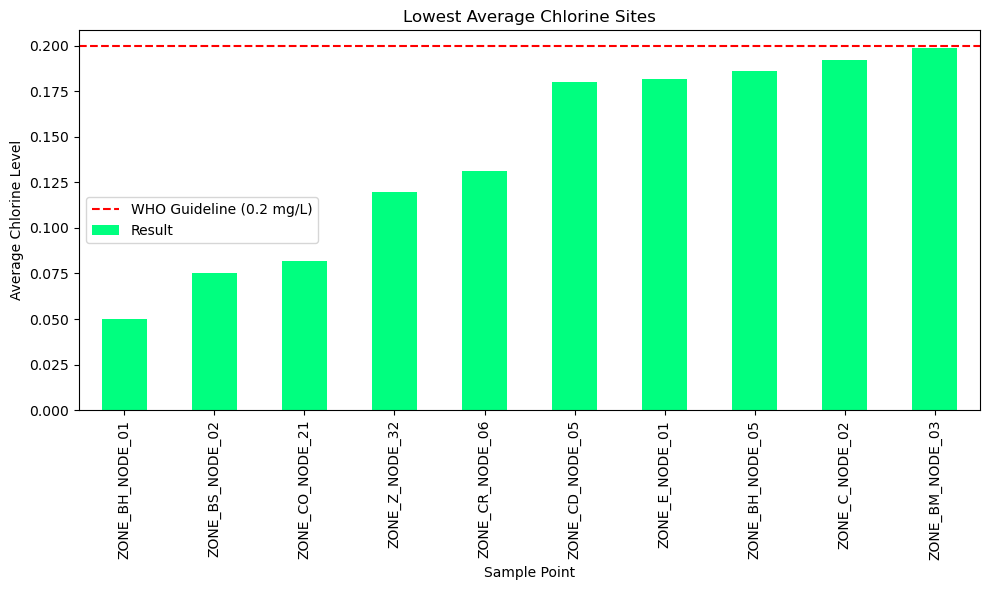

In [10]:
avg_chlorine.sort_values().head(10).plot(kind="bar", color="springgreen")

plt.title("Lowest Average Chlorine Sites")
plt.ylabel("Average Chlorine Level")
plt.xlabel("Sample Point")
plt.axhline(0.2, color="red", linestyle="--", label="WHO Guideline (0.2 mg/L)")
plt.legend()
plt.tight_layout()

plt.savefig("../figures/lowest_chlorine_sites.png", dpi=300)
plt.show()

#### **Chlorine Trend Over Time**

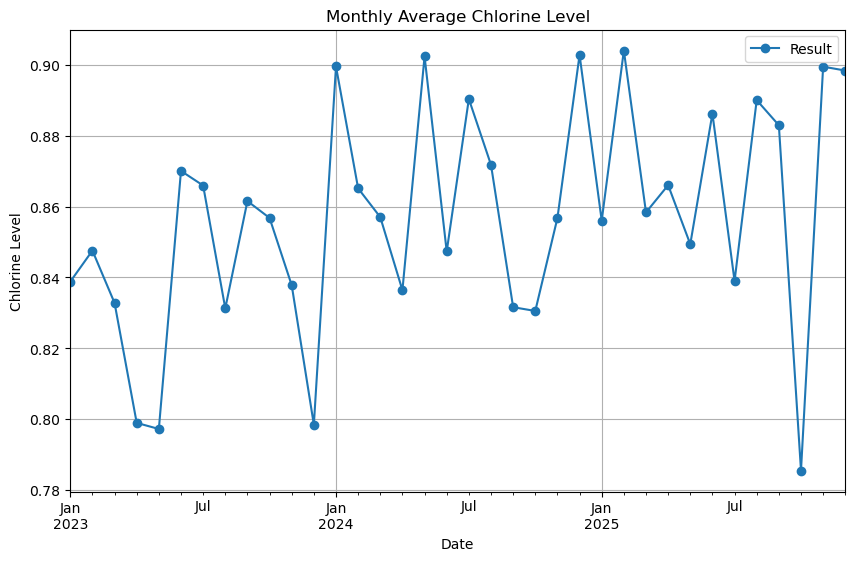

In [11]:
# Create Monthly Average Chlorine Levels
chlorine = df[df["Parameter"].str.contains("Chlorine", na=False)].copy()

chlorine = chlorine.sort_values("Result Date")

monthly = chlorine.resample("ME", on="Result Date")["Result"].mean()

monthly.plot(marker="o")

plt.title("Monthly Average Chlorine Level")
plt.xlabel("Date")
plt.ylabel("Chlorine Level")
plt.legend()

plt.grid()

plt.savefig("../figures/monthly_chlorine_trend.png", dpi=300)

plt.show()

## Limit Breach Analysis

Limit breaches are treated as operational risk signals.

In this section, I answer:
1. **Which Sample Points breach most often?** (volume)
2. **How do breaches change over time?** (trend)
3. **Which Sample Points have the highest breach rate?** (breaches relative to samples)

These views help avoid false conclusions from sites that are simply sampled more often.

In [12]:
# Check for breaches
breaches = df["Limit Breached"].value_counts()

print(breaches)

Limit Breached
False    30274
True       599
Name: count, dtype: int64


### Breaches by Site (count)

This chart highlights **where breaches are most frequent**.  
Note: high counts can be influenced by **sampling frequency**, so breach rate is also calculated later.

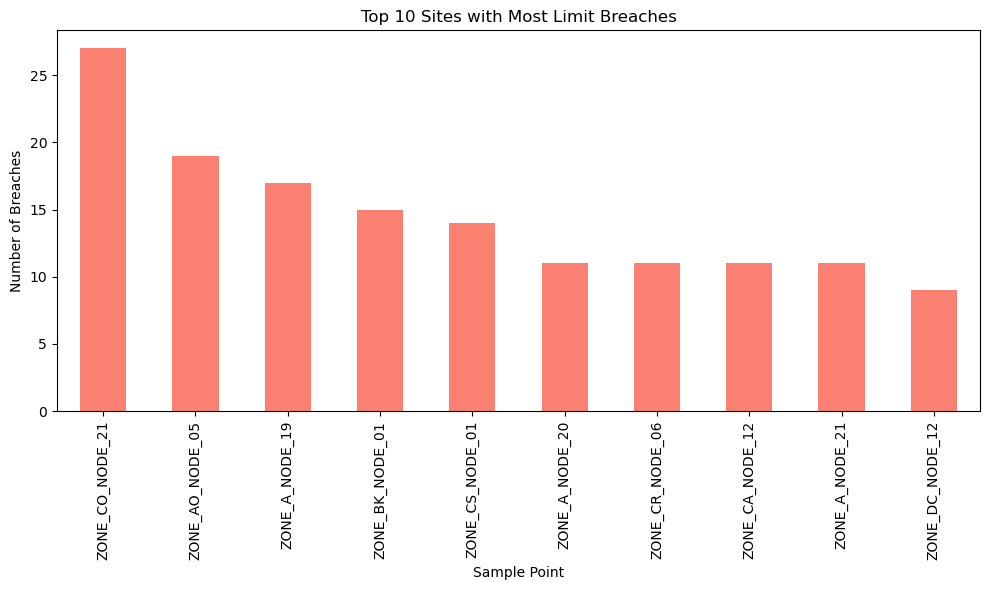

In [13]:
# Loctions with highest risk of breaches
breach_df = df[df["Limit Breached"] == True]

breaches_by_site = breach_df["Sample Point"].value_counts().head(10)

breaches_by_site.plot(kind="bar", color="salmon")

plt.title("Top 10 Sites with Most Limit Breaches")
plt.xlabel("Sample Point")
plt.ylabel("Number of Breaches")

plt.tight_layout()

plt.savefig("../figures/top_breach_sites.png", dpi=300)
plt.show()

### Breaches Over Time

This trend view helps identify:
- Seasonal or weather-driven patterns
- Operational changes (e.g., dosing adjustments)
- Periods that may require investigation

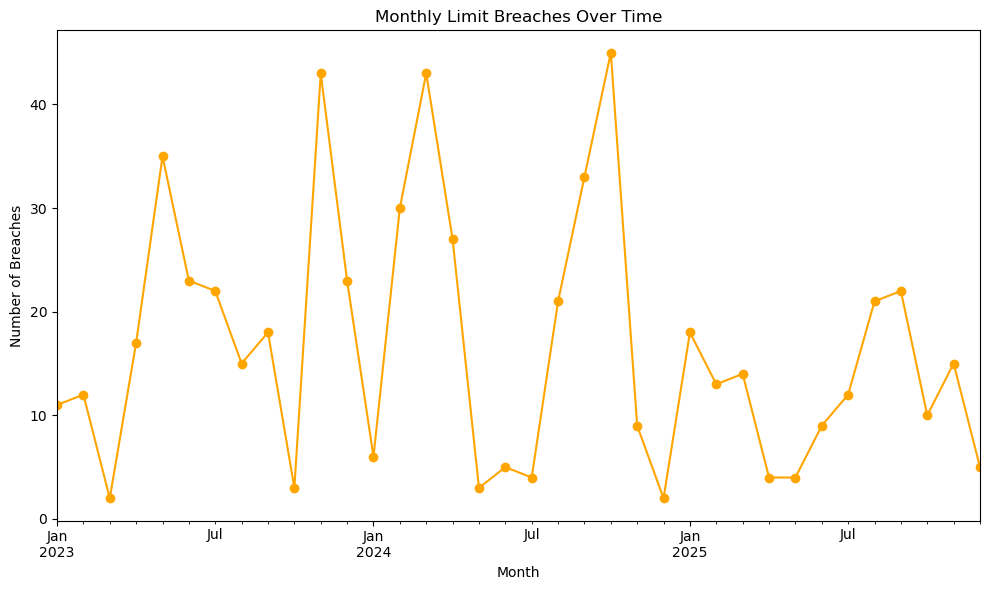

In [14]:
# Breaches over time (monthly)
breaches_over_time = breach_df.resample(
    "ME", on="Result Date"
).size()

breaches_over_time.plot(marker="o", color="orange")

plt.title("Monthly Limit Breaches Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Breaches")

plt.tight_layout()

plt.savefig("../figures/breaches_over_time_monthly.png", dpi=300)

plt.show()

### Breach Rate by Site (%)

Breach rate = (breach samples / total samples) × 100

This highlights **risk-adjusted locations** — sites that breach often *relative to how often they are sampled*.

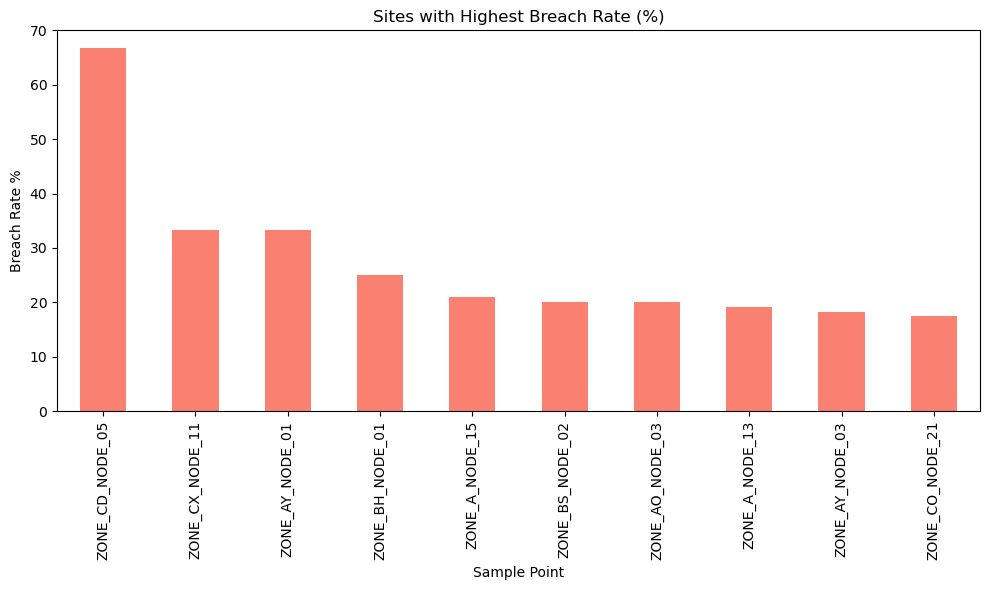

In [15]:
# Breach rate by site
total_samples = df.groupby("Sample Point").size()

breach_samples = breach_df.groupby("Sample Point").size()

breach_rate = (breach_samples / total_samples * 100).dropna()

breach_rate.sort_values(ascending=False).head(10).plot(kind="bar", color="salmon")

plt.title("Sites with Highest Breach Rate (%)")
plt.xlabel("Sample Point")
plt.ylabel("Breach Rate %")

plt.tight_layout()
plt.savefig("../figures/breach_rate_by_site.png", dpi=300)
plt.show()

In [16]:
network_avg = df["Limit Breached"].mean()*100
worst = breach_rate.max()

print("Network breach rate:", round(network_avg,2), "%")
print("Worst site breach rate:", round(worst,2), "%")

Network breach rate: 1.94 %
Worst site breach rate: 66.67 %


Network breach rate is 1.94%.

Worst performing location is significantly above average and should be prioritized.

## Temperature and Free Chlorine

Temperature can influence chlorine decay.

Here, I:
- Filter **Chlorine, Free** measurements and **temperature** measurements
- Align them by **Sample Point** and **Result Date**
- Visualize the relationship with a scatter plot + trendline
- Quantify the relationship using correlation

In [17]:
# Filter for Chlorine and Temperature measurements
chlorine = df[df["Parameter"].str.contains("Chlorine, Free", na=False)]

temperature = df[df["Parameter"].str.contains("Temp", na=False)]

In [18]:
# Match temperature and chlorine by site and time
chlorine = chlorine[["Sample Point", "Result Date", "Result"]]
chlorine = chlorine.rename(columns={"Result": "Chlorine"})

temperature = temperature[["Sample Point", "Result Date", "Result"]]
temperature = temperature.rename(columns={"Result": "Temperature"})

In [19]:
# Merge on Sample Point and Result Date
merged = pd.merge(
    chlorine,
    temperature,
    on=["Sample Point", "Result Date"],
    how="inner"
)

print(merged.head())
print("Matched samples:", len(merged))

      Sample Point         Result Date  Chlorine  Temperature
0  ZONE_CB_NODE_16 2025-03-11 13:48:00      0.53         18.5
1  ZONE_CB_NODE_14 2025-03-11 13:30:00      0.38         16.8
2  ZONE_CB_NODE_04 2025-03-11 13:10:00      0.61         17.4
3  ZONE_AP_NODE_15 2025-03-11 13:00:00      1.00         15.0
4  ZONE_AY_NODE_02 2025-03-11 12:42:00      0.81         16.1
Matched samples: 8380


Scatter Plot

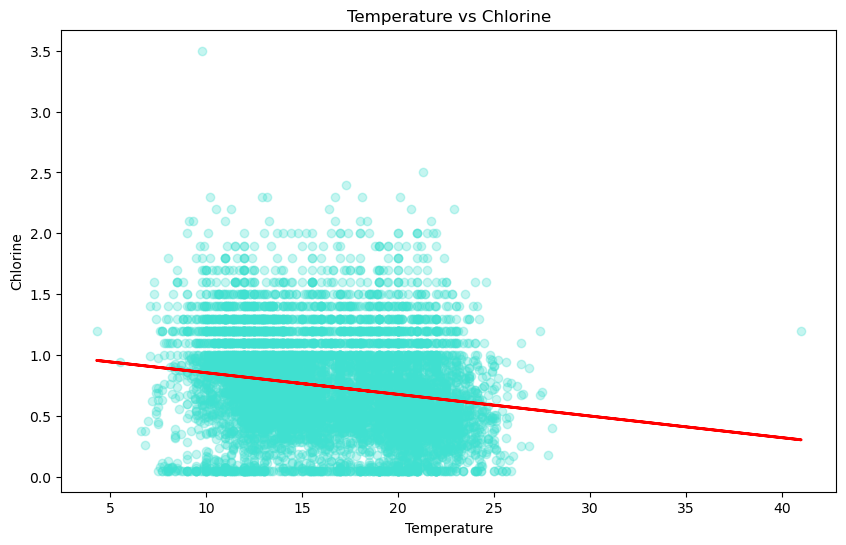

In [20]:
plt.scatter(
    merged["Temperature"],
    merged["Chlorine"],
    alpha=0.3,
    color='turquoise',
)

# Calculate trend line (linear regression)
x = merged["Temperature"]
y = merged["Chlorine"]

m, b = np.polyfit(x, y, 1)   # slope and intercept

# Plot trend line
plt.plot(x, m*x + b, color="red", linewidth=2)

plt.title("Temperature vs Chlorine")
plt.xlabel("Temperature")
plt.ylabel("Chlorine")

plt.savefig("../figures/temperature_vs_chlorine.png", dpi=300)
plt.show()

Calculate corrolation

In [21]:
correlation = merged["Temperature"].corr(merged["Chlorine"])

print("Correlation:", correlation)

Correlation: -0.1876887340949933


## Key Findings (Summary)

- Identified Sample Points with the most **limit breaches**
- Measured breach **trend over time**
- Identified Sample Points with the highest **breach rate (%)**
- Matched temperature and free chlorine readings by time and location
- Quantified the temperature–chlorine relationship using correlation

In [22]:
summary = pd.DataFrame({
    "Metric": [
        "Total measurements",
        "Total sample points",
        "Free chlorine measurements",
        "Total breaches"
    ],
    "Value": [
        len(df),
        df["Sample Point"].nunique(),
        len(chlorine),
        breach_df.shape[0]
    ]
})

summary

,Metric,Value
0,Total measurements,30873
1,Total sample points,899
2,Free chlorine measurements,8376
3,Total breaches,599


## Operational Impact

This analysis identifies high-risk sample points that may require:

• Increased flushing frequency  
• Booster chlorination  
• Infrastructure inspection  
• Sensor calibration review  

Early detection of declining chlorine trends can reduce compliance breaches and protect public health.